<a href="https://colab.research.google.com/github/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/blob/main/Tax_Cuts_on_the_Economy_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Impact of Corporate Tax Cuts on Employment, Wages, Investment, and Output

## Setup

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import statsmodels
import statsmodels.formula.api as smf

In [ ]:
# display all float values in Pandas dataframe to 2 demical places
pd.options.display.float_format = "{:,.2f}".format

Data source: all raw data are downloaded from [Statistics Canada](https://www150.statcan.gc.ca/n1/en/type/data?MM=1) and saved to [this](https://github.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec) GitHub project in the `raw_data` folder.

## Functions
We designed several functions to help reduce the work needed to clean our raw data.

In [ ]:
# a function that performs the following tasks to df, a Pandas dataframe with uncleaned data:
# - change the data type of the column year to int
# - fill all missing values based on the most previously available value of the column
# - change the data type of the column col to int (if num_decimals == 0) or 
#   float (round to num_decimals if num_decimals > 0)
# - generate dummy variables for province and sector variables;
#   eg: is_quebec = 1 if province == Quebec, 0 otherwise
def clean_data(df, col, num_decimals):
  # change the data type of the column year to int
  df['year'] = df['year'].astype(np.float32).astype(int)

  # fill all missing values based on the most previously available value of the column
  df = df.fillna(method='ffill')

  # change the data type of the column col to int or float
  df[col] = df[col].replace({',': ''}, regex=True)
  df[col] = df[col].astype(np.float32)
  if num_decimals == 0:
    df[col] = df[col].astype(int)
  else:
    df[col] = df[col].round(num_decimals)

  # get the log value of num_col
  log_var = 'log_' + col
  df[log_var] = np.log(df[col])
  
  # generate dummy variables for province, sector & time variables
  df['is_quebec'] = (df['province'] == 'Quebec')
  df['is_manu'] = (df['sector'] == 'Manufacturing')
  df['is_after_reform'] = (df['year'] >= 2014)
  df = df.astype({'is_quebec': int, 'is_manu': int, 'is_after_reform': int})

  # generate a variable that joins province and sector together
  df['province_sector'] = df.apply(lambda x: ' & '.join([x['province'], x['sector']]), axis=1)

  # if not employment data, normalize col values by province-sector groups 
  # such that log value in year 2013 is 0
  # (need to perform extra steps for employment data since it contains monthly data, 
  # so considered as a special case)
  if col != 'employment':
    df_2013 = df[['is_quebec', 'is_manu', log_var]].loc[df['year'] == 2013]
    df = df.merge(df_2013, how='left', on=['is_quebec', 'is_manu'], suffixes=('', '_2013'))
    log_norm_var = log_var + '_norm'
    log_2013_var = log_var + '_2013'
    df[log_norm_var] = df[log_var] - df[log_2013_var]

  return df

In [ ]:
# plot the time-series trend of variable var_name in dataframe df by province_sector groups
# set figure title to title and y-axis name to ylabel
def plot_graph(df, var_name, title, ylabel):
  plt.figure(figsize=(8,4))

  # plot horizontal reference line y = 0 and time-series reference line x = 2013.5
  plt.axhline(0, color='black')
  plt.axvline(2013.5)

  # plot lines by province_sector, and plot out the dots as well
  fig = sns.lineplot(data=df, x='year', y=var_name, hue='province_sector')
  sns.scatterplot(data=df, x='year', y=var_name, hue='province_sector', legend=False)

  # set legend, title, x-axis label and y-axis label
  fig.legend_.set_title('')
  sns.move_legend(fig, "upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
  fig.title.set_text(title)
  plt.xlabel('Year')
  plt.ylabel(ylabel)
  plt.show()

## Employment Data

In [ ]:
# get raw data URL from github
emp_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/employment.csv'

# load employment data to a dataframe and remove top and bottom meaningless rows
df_emp_monthly = pd.read_csv(emp_url, skiprows=11, skipfooter=18, header=None, engine='python')
df_emp_monthly = df_emp_monthly.rename(columns={0: 'province', 1: 'sector', 2: 'monthyear', 3: 'employment'})

In [ ]:
# extract year
df_emp_monthly['year'] = df_emp_monthly['monthyear'].str[-4:]

# clean data
df_emp_monthly = clean_data(df_emp_monthly, 'employment', 0)

df_emp_monthly.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   province         336 non-null    object 
 1   sector           336 non-null    object 
 2   monthyear        336 non-null    object 
 3   employment       336 non-null    int64  
 4   year             336 non-null    int64  
 5   log_employment   336 non-null    float64
 6   is_quebec        336 non-null    int64  
 7   is_manu          336 non-null    int64  
 8   is_after_reform  336 non-null    int64  
 9   province_sector  336 non-null    object 
dtypes: float64(1), int64(5), object(4)
memory usage: 26.4+ KB


In [ ]:
# aggregate df_emp_monthly by year to get annual employment; 
# aggregate by mean to get an estimate of the acutal annual employment
df_emp = df_emp_monthly.groupby(['year', 'province', 'sector', 'province_sector', 'is_quebec', 
                                 'is_manu', 'is_after_reform']).mean('employment').reset_index()
df_emp['employment'] = df_emp['employment'].astype(int)
df_emp['log_employment'] = np.log(df_emp['employment'])

df_emp_2013 = df_emp[['is_quebec', 'is_manu', 'log_employment']].loc[df_emp['year'] == 2013]
df_emp = df_emp.merge(df_emp_2013, how='left', on=['is_quebec', 'is_manu'], suffixes=('', '_2013'))
df_emp['log_employment_norm'] = df_emp['log_employment'] - df_emp['log_employment_2013']

df_emp

,year,province,sector,province_sector,is_quebec,is_manu,is_after_reform,employment,log_employment,log_employment_2013,log_employment_norm
0,2011,Ontario,Construction,Ontario & Construction,0,0,0,281774,12.55,12.60,-0.05
1,2011,Ontario,Manufacturing,Ontario & Manufacturing,0,1,0,654746,13.39,13.40,-0.01
2,2011,Quebec,Construction,Quebec & Construction,1,0,0,178295,12.09,12.14,-0.05
3,2011,Quebec,Manufacturing,Quebec & Manufacturing,1,1,0,419194,12.95,12.92,0.03
4,2012,Ontario,Construction,Ontario & Construction,0,0,0,291414,12.58,12.60,-0.02
5,2012,Ontario,Manufacturing,Ontario & Manufacturing,0,1,0,663483,13.41,13.40,0.00
6,2012,Quebec,Construction,Quebec & Construction,1,0,0,186857,12.14,12.14,-0.00
7,2012,Quebec,Manufacturing,Quebec & Manufacturing,1,1,0,417350,12.94,12.92,0.02
8,2013,Ontario,Construction,Ontario & Construction,0,0,0,296760,12.60,12.60,0.00
9,2013,Ontario,Manufacturing,Ontario & Manufacturing,0,1,0,660570,13.40,13.40,0.00


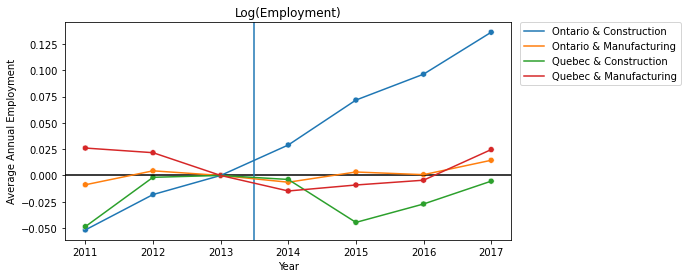

In [ ]:
# plot time series trend of annual employment by province_sector
plt.figure(figsize=(8,4))
plt.axhline(0, color='black')
plt.axvline(2013.5)
fig_emp = sns.lineplot(data=df_emp, x='year', y='log_employment_norm', hue='province_sector')
sns.scatterplot(data=df_emp, x='year', y='log_employment_norm', hue='province_sector', legend=False)
fig_emp.legend_.set_title('')
sns.move_legend(fig_emp, "upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
fig_emp.title.set_text('Log(Employment)')
plt.xlabel('Year')
plt.ylabel('Average Annual Employment')
plt.show()

In [ ]:
# regression
reg_emp = smf.ols(formula='log_employment ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                                       + is_after_reform * is_manu * is_quebec',
                 data=df_emp).fit()#cov_type='cluster',
                                  # cov_kwds={'groups': np.array(df_emp[['is_quebec', 'is_manu']])},
                                  # use_t=True)
reg_emp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_employment   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1475.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           1.03e-25
Time:                        00:33:03   Log-Likelihood:                 69.161
No. Observations:                  28   AIC:                            -122.3
Df Residuals:                      20   BIC:                            -111.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            12.5773      0.014    899.603      0.000      12.548      12.607
is_after_reform                       0.1067      0.018      5.767      0.000       0.068       0.145
is_manu                               0.8220      0.020     41.575      0.000       0.781       0.863
is_after_reform:is_manu              -0.1022      0.026     -3.906      0.001      -0.157      -0.048
is_quebec                            -0.4543      0.020    -22.977      0.000      -0.496      -0.413
is_after_reform:is_quebec            -0.1101      0.026     -4.210      0.000      -0.165      -0.056
is_manu:is_quebec                    -0.0092      0.028     -0.327      0.747      -0.067       0.049
is_after_reform:is_manu:is_quebec     0.0888      0.037      2.400      0.026       0.012       0.166
==============================================================================
Omnibus:                        2.671   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                1.375
Skew:                          -0.175   Prob(JB):                        0.503
Kurtosis:                       4.028   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Wages Data

### Total employees, all wages

#### Full-time worker, all age groups, all genders

In [ ]:
# get raw data URL from github
all_wages_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/all_wages.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_all_wages = pd.read_csv(all_wages_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_all_wages = df_all_wages.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'all_wages'})

In [ ]:
# clean data
df_all_wages = clean_data(df_all_wages, 'all_wages', 1)

df_all_wages.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   province            28 non-null     object 
 1   sector              28 non-null     object 
 2   year                28 non-null     int64  
 3   all_wages           28 non-null     float32
 4   log_all_wages       28 non-null     float32
 5   is_quebec           28 non-null     int64  
 6   is_manu             28 non-null     int64  
 7   is_after_reform     28 non-null     int64  
 8   province_sector     28 non-null     object 
 9   log_all_wages_2013  28 non-null     float32
 10  log_all_wages_norm  28 non-null     float32
dtypes: float32(4), int64(4), object(3)
memory usage: 2.2+ KB


In [ ]:
df_all_wages

,province,sector,year,all_wages,log_all_wages,is_quebec,is_manu,is_after_reform,province_sector,log_all_wages_2013,log_all_wages_norm
0,Quebec,Construction,2011,180.40,5.20,1,0,0,Quebec & Construction,5.26,-0.07
1,Quebec,Construction,2012,184.60,5.22,1,0,0,Quebec & Construction,5.26,-0.04
2,Quebec,Construction,2013,192.60,5.26,1,0,0,Quebec & Construction,5.26,0.00
3,Quebec,Construction,2014,175.20,5.17,1,0,1,Quebec & Construction,5.26,-0.09
4,Quebec,Construction,2015,162.10,5.09,1,0,1,Quebec & Construction,5.26,-0.17
5,Quebec,Construction,2016,164.70,5.10,1,0,1,Quebec & Construction,5.26,-0.16
6,Quebec,Construction,2017,176.00,5.17,1,0,1,Quebec & Construction,5.26,-0.09
7,Quebec,Manufacturing,2011,456.70,6.12,1,1,0,Quebec & Manufacturing,6.13,-0.01
8,Quebec,Manufacturing,2012,459.30,6.13,1,1,0,Quebec & Manufacturing,6.13,-0.00
9,Quebec,Manufacturing,2013,461.10,6.13,1,1,0,Quebec & Manufacturing,6.13,0.00


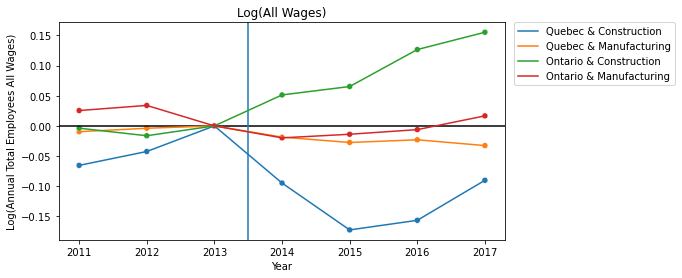

In [ ]:
# plot time series trend of total employees all wages by province_sector
plot_graph(df_all_wages, 'log_all_wages_norm', 'Log(All Wages)', 'Log(Annual Total Employees All Wages)')
# plt.figure(figsize=(8,4))
# plt.axhline(0, color='black')
# plt.axvline(2013.5)
# fig_all_wages = sns.lineplot(data=df_all_wages, x='year', y='log_all_wages_norm', hue='province_sector')
# sns.scatterplot(data=df_all_wages, x='year', y='log_all_wages_norm', hue='province_sector', legend=False)
# fig_all_wages.legend_.set_title('')
# sns.move_legend(fig_all_wages, "upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0)
# fig_all_wages.title.set_text('Log(All Wages)')
# plt.xlabel('Year')
# plt.ylabel('Log(Annual Total Employees All Wages)')
# plt.show()

In [ ]:
# regression
reg_all_wages = smf.ols(formula='log_all_wages ~ is_after_reform * is_manu + is_after_reform * is_quebec \
                                       + is_after_reform * is_manu * is_quebec',
                        data=df_all_wages).fit()
reg_all_wages.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_all_wages   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1256.
Date:                Tue, 06 Dec 2022   Prob (F-statistic):           5.11e-25
Time:                        00:54:39   Log-Likelihood:                 64.340
No. Observations:                  28   AIC:                            -112.7
Df Residuals:                      20   BIC:                            -102.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             5.6652      0.017    341.110      0.000       5.631       5.700
is_after_reform                       0.1063      0.022      4.838      0.000       0.060       0.152
is_manu                               0.9028      0.023     38.436      0.000       0.854       0.952
is_after_reform:is_manu              -0.1319      0.031     -4.245      0.000      -0.197      -0.067
is_quebec                            -0.4406      0.023    -18.758      0.000      -0.490      -0.392
is_after_reform:is_quebec            -0.1988      0.031     -6.397      0.000      -0.264      -0.134
is_manu:is_quebec                     0.0017      0.033      0.051      0.960      -0.068       0.071
is_after_reform:is_manu:is_quebec     0.2034      0.044      4.630      0.000       0.112       0.295
==============================================================================
Omnibus:                        0.181   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.914   Jarque-Bera (JB):                0.105
Skew:                           0.123   Prob(JB):                        0.949
Kurtosis:                       2.829   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Full-time worker, all age groups, by gender

### Average hourly wage rate

#### Full-time worker, all age groups, all genders

In [ ]:
# get raw data URL from github
hourly_wage_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/hourly_wage.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_hourly_wage = pd.read_csv(hourly_wage_url, skiprows=14, skipfooter=15, header=None, engine='python')

# name the headers
df_hourly_wage = df_hourly_wage.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'hourly_wage'})

In [ ]:
# clean data
df_hourly_wage = clean_data(df_hourly_wage, 'hourly_wage', 2)

df_hourly_wage.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   province              28 non-null     object 
 1   sector                28 non-null     object 
 2   year                  28 non-null     int64  
 3   hourly_wage           28 non-null     float32
 4   log_hourly_wage       28 non-null     float32
 5   is_quebec             28 non-null     int64  
 6   is_manu               28 non-null     int64  
 7   is_after_reform       28 non-null     int64  
 8   province_sector       28 non-null     object 
 9   log_hourly_wage_2013  28 non-null     float32
 10  log_hourly_wage_norm  28 non-null     float32
dtypes: float32(4), int64(4), object(3)
memory usage: 2.2+ KB


In [ ]:
df_hourly_wage

,province,sector,year,hourly_wage,log_hourly_wage,is_quebec,is_manu,is_after_reform,province_sector,log_hourly_wage_2013,log_hourly_wage_norm
0,Quebec,Construction,2011,24.79,3.21,1,0,0,Quebec & Construction,3.27,-0.06
1,Quebec,Construction,2012,25.48,3.24,1,0,0,Quebec & Construction,3.27,-0.03
2,Quebec,Construction,2013,26.24,3.27,1,0,0,Quebec & Construction,3.27,0.00
3,Quebec,Construction,2014,26.68,3.28,1,0,1,Quebec & Construction,3.27,0.02
4,Quebec,Construction,2015,27.13,3.30,1,0,1,Quebec & Construction,3.27,0.03
5,Quebec,Construction,2016,28.32,3.34,1,0,1,Quebec & Construction,3.27,0.08
6,Quebec,Construction,2017,29.30,3.38,1,0,1,Quebec & Construction,3.27,0.11
7,Quebec,Manufacturing,2011,21.76,3.08,1,1,0,Quebec & Manufacturing,3.13,-0.05
8,Quebec,Manufacturing,2012,22.65,3.12,1,1,0,Quebec & Manufacturing,3.13,-0.01
9,Quebec,Manufacturing,2013,22.79,3.13,1,1,0,Quebec & Manufacturing,3.13,0.00


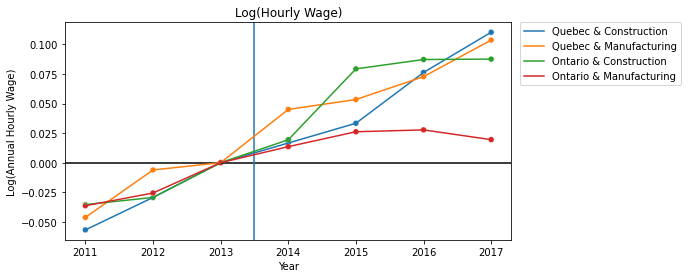

In [ ]:
plot_graph(df_hourly_wage, 'log_hourly_wage_norm', 'Log(Hourly Wage)', 'Log(Annual Hourly Wage)')

#### Full-time worker, all age groups, by gender

## Investment Data

### Total non-residential capital

In [ ]:
# get raw data URL from github
inv_non_res_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_non_res.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_non_res = pd.read_csv(inv_non_res_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_non_res = df_inv_non_res.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [ ]:
# clean data
df_inv_non_res = clean_data(df_inv_non_res, 'investment', 0)

df_inv_non_res.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   province             28 non-null     object 
 1   sector               28 non-null     object 
 2   year                 28 non-null     int64  
 3   investment           28 non-null     int64  
 4   log_investment       28 non-null     float64
 5   is_quebec            28 non-null     int64  
 6   is_manu              28 non-null     int64  
 7   is_after_reform      28 non-null     int64  
 8   province_sector      28 non-null     object 
 9   log_investment_2013  28 non-null     float64
 10  log_investment_norm  28 non-null     float64
dtypes: float64(3), int64(5), object(3)
memory usage: 2.6+ KB


In [ ]:
df_inv_non_res

,province,sector,year,investment,log_investment,is_quebec,is_manu,is_after_reform,province_sector,log_investment_2013,log_investment_norm
0,Quebec,Construction,2011,1257,7.14,1,0,0,Quebec & Construction,7.09,0.05
1,Quebec,Construction,2012,1177,7.07,1,0,0,Quebec & Construction,7.09,-0.02
2,Quebec,Construction,2013,1200,7.09,1,0,0,Quebec & Construction,7.09,0.00
3,Quebec,Construction,2014,861,6.76,1,0,1,Quebec & Construction,7.09,-0.33
4,Quebec,Construction,2015,878,6.78,1,0,1,Quebec & Construction,7.09,-0.31
5,Quebec,Construction,2016,828,6.72,1,0,1,Quebec & Construction,7.09,-0.37
6,Quebec,Construction,2017,1154,7.05,1,0,1,Quebec & Construction,7.09,-0.04
7,Quebec,Manufacturing,2011,6727,8.81,1,1,0,Quebec & Manufacturing,8.77,0.04
8,Quebec,Manufacturing,2012,6717,8.81,1,1,0,Quebec & Manufacturing,8.77,0.04
9,Quebec,Manufacturing,2013,6434,8.77,1,1,0,Quebec & Manufacturing,8.77,0.00


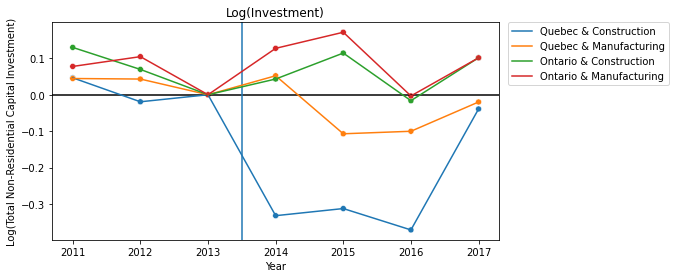

In [ ]:
plot_graph(df_inv_non_res, 'log_investment_norm', 'Log(Investment)', 'Log(Total Non-Residential Capital Investment)')

### Machinery and equipment

In [ ]:
# get raw data URL from github
inv_me_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_machinery_equipment.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_me = pd.read_csv(inv_me_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_me = df_inv_me.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [ ]:
# clean data
df_inv_me = clean_data(df_inv_me, 'investment', 0)

df_inv_me.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   province             28 non-null     object 
 1   sector               28 non-null     object 
 2   year                 28 non-null     int64  
 3   investment           28 non-null     int64  
 4   log_investment       28 non-null     float64
 5   is_quebec            28 non-null     int64  
 6   is_manu              28 non-null     int64  
 7   is_after_reform      28 non-null     int64  
 8   province_sector      28 non-null     object 
 9   log_investment_2013  28 non-null     float64
 10  log_investment_norm  28 non-null     float64
dtypes: float64(3), int64(5), object(3)
memory usage: 2.6+ KB


In [ ]:
df_inv_me

,province,sector,year,investment,log_investment,is_quebec,is_manu,is_after_reform,province_sector,log_investment_2013,log_investment_norm
0,Quebec,Construction,2011,1028,6.94,1,0,0,Quebec & Construction,6.87,0.07
1,Quebec,Construction,2012,967,6.87,1,0,0,Quebec & Construction,6.87,0.01
2,Quebec,Construction,2013,962,6.87,1,0,0,Quebec & Construction,6.87,0.00
3,Quebec,Construction,2014,648,6.47,1,0,1,Quebec & Construction,6.87,-0.40
4,Quebec,Construction,2015,670,6.51,1,0,1,Quebec & Construction,6.87,-0.36
5,Quebec,Construction,2016,634,6.45,1,0,1,Quebec & Construction,6.87,-0.42
6,Quebec,Construction,2017,909,6.81,1,0,1,Quebec & Construction,6.87,-0.06
7,Quebec,Manufacturing,2011,2598,7.86,1,1,0,Quebec & Manufacturing,7.80,0.06
8,Quebec,Manufacturing,2012,2563,7.85,1,1,0,Quebec & Manufacturing,7.80,0.05
9,Quebec,Manufacturing,2013,2442,7.80,1,1,0,Quebec & Manufacturing,7.80,0.00


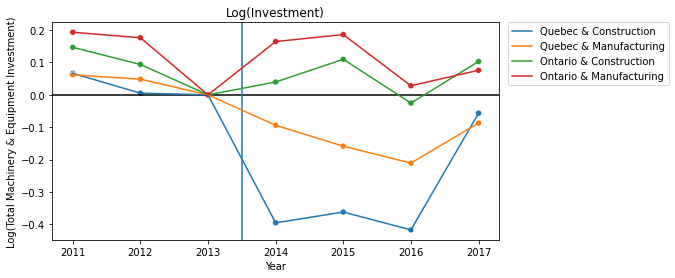

In [ ]:
plot_graph(df_inv_me, 'log_investment_norm', 'Log(Investment)', 'Log(Total Machinery & Equipment Investment)')

### Intellectual property products

In [ ]:
# get raw data URL from github
inv_ip_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/investment_ip.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_inv_ip = pd.read_csv(inv_ip_url, skiprows=13, skipfooter=6, header=None, engine='python')

# name the headers
df_inv_ip = df_inv_ip.rename(columns={0: 'province', 1: 'sector', 2: 'year', 3: 'investment'})

In [ ]:
# clean data
df_inv_ip = clean_data(df_inv_ip, 'investment', 0)

df_inv_ip.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28 entries, 0 to 27
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   province             28 non-null     object 
 1   sector               28 non-null     object 
 2   year                 28 non-null     int64  
 3   investment           28 non-null     int64  
 4   log_investment       28 non-null     float64
 5   is_quebec            28 non-null     int64  
 6   is_manu              28 non-null     int64  
 7   is_after_reform      28 non-null     int64  
 8   province_sector      28 non-null     object 
 9   log_investment_2013  28 non-null     float64
 10  log_investment_norm  28 non-null     float64
dtypes: float64(3), int64(5), object(3)
memory usage: 2.6+ KB


In [ ]:
df_inv_ip

,province,sector,year,investment,log_investment,is_quebec,is_manu,is_after_reform,province_sector,log_investment_2013,log_investment_norm
0,Quebec,Construction,2011,52,3.95,1,0,0,Quebec & Construction,4.23,-0.28
1,Quebec,Construction,2012,56,4.03,1,0,0,Quebec & Construction,4.23,-0.21
2,Quebec,Construction,2013,69,4.23,1,0,0,Quebec & Construction,4.23,0.00
3,Quebec,Construction,2014,66,4.19,1,0,1,Quebec & Construction,4.23,-0.04
4,Quebec,Construction,2015,62,4.13,1,0,1,Quebec & Construction,4.23,-0.11
5,Quebec,Construction,2016,47,3.85,1,0,1,Quebec & Construction,4.23,-0.38
6,Quebec,Construction,2017,56,4.03,1,0,1,Quebec & Construction,4.23,-0.21
7,Quebec,Manufacturing,2011,2650,7.88,1,1,0,Quebec & Manufacturing,8.01,-0.13
8,Quebec,Manufacturing,2012,2643,7.88,1,1,0,Quebec & Manufacturing,8.01,-0.13
9,Quebec,Manufacturing,2013,3010,8.01,1,1,0,Quebec & Manufacturing,8.01,0.00


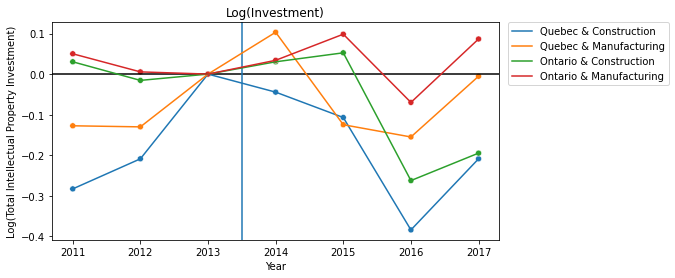

In [ ]:
plot_graph(df_inv_ip, 'log_investment_norm', 'Log(Investment)', 'Log(Total Intellectual Property Investment)')

## Total Output Data

In [ ]:
# get raw data URL from github
output_url = 'https://raw.githubusercontent.com/ting486/Corporate-Tax-Cuts-for-Small-Businesses-in-Quebec/main/raw_data/output1.csv'

# load all wages data to a dataframe and remove top and bottom meaningless rows
df_output_subsec = pd.read_csv(output_url, skiprows=11, skipfooter=12, header=None, engine='python', on_bad_lines='skip')

# name the headers
df_output_subsec = df_output_subsec.rename(columns={0: 'sector', 1: 'year', 2: 'Ontario', 3: 'Quebec'})

In [ ]:
# fill all missing values based on the most previously available value of the column
df_output_subsec = df_output_subsec.fillna(method='ffill')

# unpivot the table to match the format of other tables
df_output_subsec = df_output_subsec.melt(id_vars=['sector', 'year'], var_name='province', value_name='output')

# combine all construction subsectors into an overall construction sector
df_output_subsec['sector'].loc[df_output_subsec['sector'].str.contains('construction')] = 'Construction'
df_output_subsec['sector'].loc[df_output_subsec['sector'].str.contains('Manufacturing')] = 'Manufacturing'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
# clean data
df_output_subsec = clean_data(df_output_subsec, 'output', 1)

In [ ]:
df_output = df_output_subsec.groupby(['year', 'province', 'sector', 
                               'province_sector', 'is_quebec', 'is_manu']).sum('output').reset_index()
df_output['output'] = df_output['output'].round(1)

df_output.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             28 non-null     int64  
 1   province         28 non-null     object 
 2   sector           28 non-null     object 
 3   province_sector  28 non-null     object 
 4   is_quebec        28 non-null     int64  
 5   is_manu          28 non-null     int64  
 6   output           28 non-null     float32
 7   log_output       28 non-null     float32
 8   is_after_reform  28 non-null     int64  
 9   log_output_2013  28 non-null     float32
 10  log_output_norm  28 non-null     float32
dtypes: float32(4), int64(4), object(3)
memory usage: 2.1+ KB


In [ ]:
df_output

,year,province,sector,province_sector,is_quebec,is_manu,output,log_output,is_after_reform,log_output_2013,log_output_norm
0,2011,Ontario,Construction,Ontario & Construction,0,0,"254,444.50",217.88,0,219.24,-1.36
1,2011,Ontario,Manufacturing,Ontario & Manufacturing,0,1,"145,645.09",11.89,0,11.89,-0.01
2,2011,Quebec,Construction,Quebec & Construction,1,0,"405,384.50",231.86,0,232.87,-1.01
3,2011,Quebec,Manufacturing,Quebec & Manufacturing,1,1,"289,492.41",12.58,0,12.62,-0.04
4,2012,Ontario,Construction,Ontario & Construction,0,0,"275,696.00",220.02,0,219.24,0.77
5,2012,Ontario,Manufacturing,Ontario & Manufacturing,0,1,"148,294.41",11.91,0,11.89,0.01
6,2012,Quebec,Construction,Quebec & Construction,1,0,"426,013.50",232.58,0,232.87,-0.29
7,2012,Quebec,Manufacturing,Quebec & Manufacturing,1,1,"301,628.50",12.62,0,12.62,0.00
8,2013,Ontario,Construction,Ontario & Construction,0,0,"262,985.50",219.24,0,219.24,0.00
9,2013,Ontario,Manufacturing,Ontario & Manufacturing,0,1,"146,463.50",11.89,0,11.89,0.00


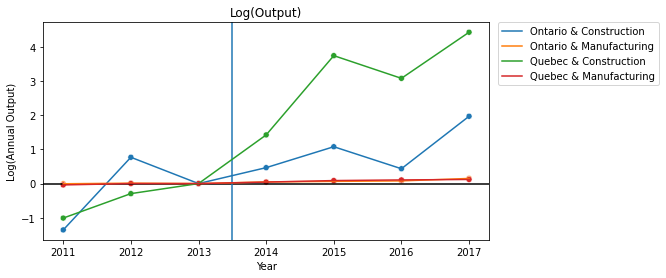

In [ ]:
plot_graph(df_output, 'log_output_norm', 'Log(Output)', 'Log(Annual Output)')